## Remake a DIII-D NT equilibrium with new, scanable coils

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
sys.path.append('/Applications/OpenFUSIONToolkit/python')
# tokamaker_python_path = os.getenv('OFT_ROOTPATH')
# if tokamaker_python_path is not None:
#     sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk

In [3]:
def solve_eqdsk(
        eqdsk_name = 'g192185.02440',
        mesh = 'DIIID_mesh_scantest.h5',
        ifplot = True,
        ifsave = True
):
    mygs = TokaMaker()

    mygs.settings.maxits = 200

    eqdsk = read_eqdsk(f'gEQDSKs/{eqdsk_name}')

    ### Load mesh

    mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh(f'meshes/{mesh}')
    mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
    mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
    mygs.setup(order=2,F0=eqdsk['rcentr']*eqdsk['bcentr'])

    ### Define a vertical stability coil

    vsc_signs = np.zeros((mygs.ncoils,), dtype=np.float64)
    vsc_signs[[mygs.coil_sets['F1A']['id'], mygs.coil_sets['F1B']['id']]] = [1.0,-1.0]
    mygs.set_coil_vsc(vsc_signs)

    ### Set global targets

    mygs.set_targets(Ip=eqdsk['ip'], pax=eqdsk['pres'][0])

    ### Set shape targets
    
    isoflux_pts = eqdsk['rzout'].copy()
    mygs.set_isoflux(isoflux_pts, weights=1e4*np.ones(len(isoflux_pts)))

    ### Define coil regularization matrix

    # Initialize regularization matrix and target/weight vectors
    coil_reg_mat = np.eye(mygs.ncoils+1, dtype=np.float64)

    # Pass regularization terms to TokaMaker
    mygs.set_coil_reg(coil_reg_mat)

    ### Define hard limits on coil currents

    coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
    coil_bounds[:,0] = -1E6; coil_bounds[:,1] = 1E6
    mygs.set_coil_bounds(coil_bounds)

    ### Define flux functions

    ffprim = eqdsk['ffprim']
    pprime = eqdsk['pprime']

    psi_eqdsk = np.linspace(0.0,1.0,np.size(ffprim))
    psi_sample = np.linspace(0.0,1.0,50)

    psi_prof = np.copy(psi_sample)
    ffp_prof = np.transpose(np.vstack((psi_prof,np.interp(psi_sample,psi_eqdsk,ffprim)))).copy()
    pp_prof = np.transpose(np.vstack((psi_prof,np.interp(psi_sample,psi_eqdsk,pprime)))).copy()

    mygs.set_profiles(ffp_prof={'type': 'linterp', 'y': ffp_prof[:,1], 'x': psi_sample},pp_prof={'type': 'linterp', 'y': pp_prof[:,1], 'x': psi_sample})

    ### Initialize equilibrium
    
    R0 = 1.7
    Z0 = 0.0
    a = 0.5
    kappa = 1.3
    delta = -0.4

    err_flag = mygs.init_psi(R0, Z0, a, kappa, delta)
    print(err_flag)

    ### Solve equilibrium

    err_flag = mygs.solve()
    print(err_flag)

    if ifplot:
        ### Plot equilibrium
        fig, ax = plt.subplots(1,1)
        mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
        mygs.plot_psi(fig,ax,vacuum_nlevels=4)
        _ = ax.plot(eqdsk['rzout'][:,0], eqdsk['rzout'][:,1],'r--')

    if ifsave:
        mygs.save_eqdsk(f"gEQDSKs/{eqdsk_name}_tm_{mesh.split('.h5')[0]}", nr = 200, nz = 200, lcfs_pad = 0.001)

    mygs.reset()

mesh_n5_d2-4-1-3-3-4.h5
#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   HEAD_detached_at_v1.0.0-beta4
Revision id:          aba6d8f
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  10
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  1.100E+01
    # of points  =    5352
    # of edges   =   15921
    # of cells   =   10570
    # of boundary points =     132
    # of boundary edges  =     132
    # of boundary cells  =     132
  Resolution statistics:
    hmin =

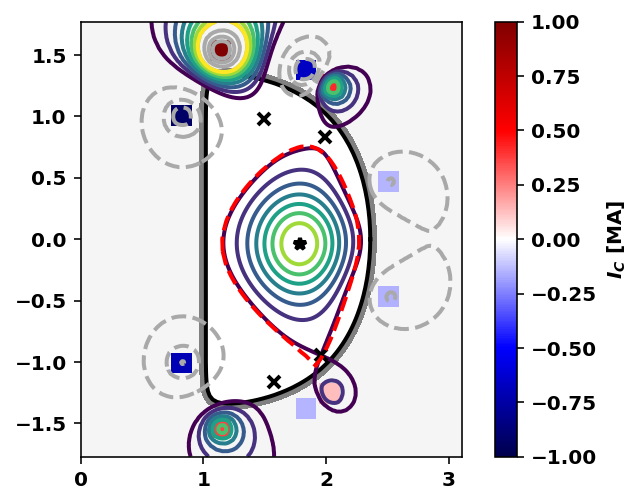

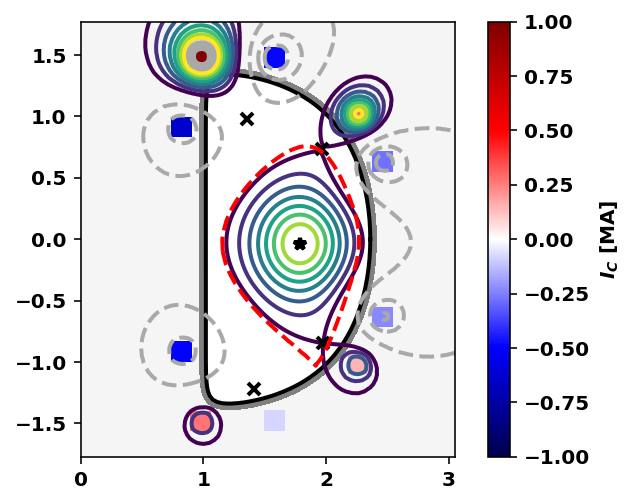

In [4]:
eqdsk_name = 'g192185.02440'

reject_list = ['mesh_n5_d4-1-2-3-4-2.h5']

for mesh in [x for x in os.listdir('meshes') if 'n5' in x]:
    if f"{eqdsk_name}_tm_{mesh.split('.h5')[0]}" not in os.listdir('gEQDSKs'):
        if mesh not in reject_list:
            print(mesh)
            solve_eqdsk(eqdsk_name=eqdsk_name, mesh=mesh)